# Baseline_model.ipynb
The goal of this model is to predict whether a refugee will be granted asylum based on information available before the actual hearing. For this baseline model, we fit an L2 logistic regression using three variables of interest, described below.

#### Features  
   * `nat`: applicant's nationality (one hot encoded)
   * `tracid`: judge's identification number (one hot encoded)
   * `osc_date`: the Notice to Appear date for each proceeding (continuous)  
  
<br>
We define 'asylum granted' in two different ways. These slightly different definitions require different cleaning of the data, which lead to the following two datasets we use in the baseline model.
1. `merged_full_asylum_master_app.csv`: individual (indicated by unique idnProceeding) is granted Full Asylum. 
2. `merged_any_master_app.csv`: individual is granted at least one of the following: Full Asylum, Withholding of Removal, Protection Under Convention Against Torture. 


## Format features
Variables of interest had been cleaned and merged in Cleaning.ipynb. However, these features need to be transformed into the appropriate format (e.g., one hot encoded) for this model.

In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy.sparse import csc_matrix
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split

pd.set_option('precision', 5)

/usr/local/anaconda/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# LOAD IN CLEANED DATASET
path = '/home/emilyboeke/'

#master_app = pd.read_csv(path + 'merged2_master_app.csv', low_memory=False)
#master_app = pd.read_csv(path + 'merged_any_master_app.csv', low_memory=False)
master_app = pd.read_csv(path + 'merged_full_asylum_master_app.csv', low_memory=False)

training_data = pd.read_csv(path + 'train_cases_any_asylum.csv', low_memory=False)
testing_data = pd.read_csv(path + 'test_cases_any_asylum.csv', low_memory=False)

In [3]:
# ADDITIONAL LAST MINUTE DATA CLEANING

# dropping auto-generated index column
master_app = master_app.drop(master_app.columns[0], axis=1)

# change dec to binary variable
master_app.loc[(master_app["dec"] == 'DENY'),'dec'] = 0
master_app.loc[(master_app["dec"] == 'GRANT'),'dec'] = 1

# delete NTA dates before 1985
master_app['osc_date'] = pd.to_datetime(master_app['osc_date'],infer_datetime_format = True)
master_app = master_app[master_app.osc_date.dt.year>1984]

#master_app.describe()

In [4]:
# CHANGE OSC_DATE TO CONTINUOUS NUMBER (number of days since startdate)

osc_date_cont = []
startdate = np.datetime64('1984-01-01') # earliest date. from which timedelta is calculated

# change osc_date to continuous number
for i in master_app.index:
    x = master_app.loc[i,'osc_date'] - startdate
    osc_date_cont.append(x.days)
    
osc_date_cont = np.array(osc_date_cont)

In [5]:
# ONE HOT ENCODE CATEGORICAL VARIABLES

# change string nationalities to integer categories 
le = LabelEncoder()
nat = le.fit_transform(master_app['nat'])
nat = np.reshape(nat_int,[len(nat),1])

# get N x 2 array of features of interest
feat_int = np.concatenate((master_app[['tracid']], nat), axis=1)
feat_int.shape

# get one hot encoder of features
enc = OneHotEncoder()
enc.fit(feat_int)  
enc.feature_indices_

# create sparse matrix of all observations in Compressed Sparse Row format
feat_int = enc.transform(feat_int)

In [6]:
# CONCATENATE ONE HOT ENCODED FEATURES WITH CONTINUOUS FEATURE

# changes csr to csc, bc simpler to work with columns than rows
feat_int = scipy.sparse.csr_matrix.tocsc(feat_int)

# concatenating relevant fields
new_data = np.concatenate((feat_int.data, osc_date_cont)) # non-zero values in matrix
new_indices = np.concatenate((feat_int.indices, range(len(osc_date_cont)))) # row indices for each column
new_ind_ptr = np.append(feat_int.indptr, feat_int.indptr[-1]+len(osc_date_cont))

# making new matrix
final_feature_mat = csc_matrix((new_data, new_indices, new_ind_ptr))

## Implement L2 logistic regression

We want to withhold a subset of the data for model comparisons across all models at the end. Therefore, we currently exclude 20% of the data from any analyses. All training and validation will be completed on the remaining 80% of the data.  
  
We use sklearn to define a logistic regression with an L2 penalty.

In [7]:
X, X_test_donttouch, y, y_test_donttouch = train_test_split(
    final_feature_mat, master_app['dec'], test_size=0.2, random_state=0)

In [8]:
alpha = 1
LogReg = LogisticRegression(penalty='l2',C = alpha) # defining model: logistic regression with L2 penalization

### Implement model on train/validation set

In [14]:
# split data into train and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = LogReg.fit(X_train, y_train)
print(model.score(X_test,y_test))

0.7370167717378375


We find that the accuracy of predicting grant rate just from the applicant's nationality, the judge's ID, and the Notice to Appear date is sufficient to predict the following for each data set:  
  * `merged2_master_app.csv`: around 73% accuracy
  * `merged_any_master_app.csv`: around 73.3% accuracy
  * `merged_full_asylum_master_app.csv`: around 73.5% accuracy



In [10]:
# print some summary stats on the weights
coeffs = (model.coef_[0])

print(min(coeffs))
print(max(coeffs))
print(np.mean(coeffs))

-2.0981108075116643
1.3667575373031282
-0.005759383908015544


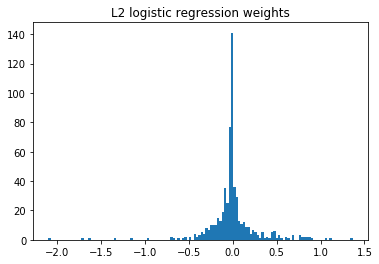

In [12]:
# plot weights

import matplotlib.pyplot as plt
plt.hist(coeffs, bins='auto') 
plt.title("L2 logistic regression weights")
plt.show()

In [ ]:
sklearn.linear_model.LogisticRegressionCV

In [ ]:
# LOOK AT LARGEST MAGNITUDE WEIGHTS

from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier


# build a classifier
clf = RandomForestClassifier(n_estimators=20)


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

### Evaluate model using k-fold cross-validation

In [13]:
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogReg, X, y, scoring='accuracy', cv=10)
print(scores)
print(scores.mean())

[0.73413265 0.73767723 0.73558379 0.73441812 0.73604701 0.7358329
 0.73326355 0.73890184 0.73590427 0.73685588]
0.735861722359136
